# 06. PyTorch Transfer Learning

Transfer Learning allows us to take the patterns (weights) that another model has learnt from another problem and use them to solve our own problem.

E.g. we can take a model that has learnt from datasets like ImageNet and use it to power our model (to differentiate between sushi, pizza and steak).

We can also take the weights of a LLM and use it to classify different text samples.

If we use a model with pre-learnt weights on a similar problem, we can get great results with less custom-data.

We can find the latest pre-trained deep learning models from
1. PyTorch Domain libraries: `torchvision.models`, `torchtext.models`, etc.
2. HuggingFace Hub: https://huggingface.co/models
3. timm (PyTorch Image Models)
4. Paperswithcode: https://paperswithcode.com

## 0. Setup

In [33]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [34]:
from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine

In [35]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [36]:
import os
import zipfile
from pathlib import Path
import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Download the image folder if it doesn't exist
if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)
        
    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory already exists


In [37]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual)

When using a pre-trained model, it is important that our custom data is prepared in the same way as the original data used to train the model was prepared.

<blockquote>ll pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
</blockquote>

> **NOTE:** some pretrained models from torchvision.models in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

<blockquote>Question: Where did the mean and standard deviation values come from? Why do we need to do this?

These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
</blockquote>

In [38]:
# Creating a transforms pipeline manually (needed for older version of PyTorch)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Reshape images to 224x224
    transforms.ToTensor(),                  # Convert images to values between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                        std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [39]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ca1e0f2710>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (automatic creation)

We can also automatically create a transform for a pretrained model. When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`
Where,
* EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many differnt model architecture options in torchvision.models).
* DEFAULT means the best available weights (the best performance in ImageNet).
    * Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option. See the torchvision.models documentation for more.

In [40]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [41]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [42]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ca1e0f2020>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.1 Which model should you use?

While bigger models mean better performance, it also means more complex models, which may not be suitable for some devices. So the choice of the model depends on the performance required and the amount of compute/complexity that we can afford.

This is called the performance v/s speed tradeoff.

### 3.2 Setting up a pretrained model

We will be using `torchvision.models.efficientnet_b0()`.

In [43]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT        # DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

A major benefit of transfer learning is that we can use a model created by expert engineers directly on our problem.

`efficientnet_b0()` comes in 3 parts:
1. `features`: A collection of convolution layers and other activation layers to learn a base representation of vision data (also called feature extractor).
2. `avgpool`: Takes the average of the output of the `features` layer(s) and turns it into a feature vector.
3. `classifier`: Turn the feature vector into a vector with the same dimensionality as the number of required output classes.

### 3.1 Getting a summary of our model with `torchinfo.summary()`

In [44]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 224, 224),   # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"], # specify what information to show
        col_width=20,       # how wide each column should be
        row_settings=["var_names"]      # what information to show on each row
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Our TinyVGG model had 8,083 parameters while efficientnet_b0 model has 5,288,548 parameters, an increase of ~654x!

### 3.4 Freezing the base model and changing the output layer to suit our needs

In transfer learning, we usually freeze some base layers of a pretrained model (usually the `features` section) and then adjust the output layers (the head/classifer layers) to suit our needs.

We can change the output layers to fit our needs. The original model comes with the default `out_features` value as 1,000 as ImageNet has 1000 classes.

> By freezing, we mean keeping the layers as they were during training. E.g. if a model has pretrained layers, freezing them would be keeping the pretrained weights/patterns that the model has learnt from ImageNet as a backbone and then only change the output layers.

We can freeze all the layers in the `features` section by setting `requires_grad=False`. A parameter with `requires_grad=False` in 'untrainable' or 'frozen'.

In [45]:
# Freezing the base layers in the features section
for param in model.features.parameters():       # Parsing through all the feature parameters
    param.requires_grad = False

In [46]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Now that we've frozen the feature extractor layers, we can focus on adjusting the `classifier` portion of our pretrained model as per our needs.

By default, `out_features=1000`, but as we have only 3 classes: pizza, steak and sushi, we need `out_features=3`. We can change the `classifier` portion of our model by creating a new series of layers.

By looking at the model's output, we find out that currently the `classifier` portion of our model consists of a dropout layer and a linear layer.

We will keep the dropout layer as it is but we'll change the `out_features` of the Linear layer from 1000 to 3.

In [47]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (1 output unit for each class)
output_shape = len(class_names)             # 3 in our case

# Recreate the classifier layer and send it to the target device
model.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),      # Unchanged
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,  # Same as our number of classes
                    bias=True).to(device)
)

In [48]:
# Summarizing the model after freezing the base layers and changing the classifier
summary(model,
        input_size=(32, 3, 24, 24),
        verbose=False,              # True = more info, False = less info
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 24, 24]      [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 24, 24]      [32, 1280, 1, 1]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 24, 24]      [32, 32, 12, 12]     --                   False
│    │    └─Conv2d (0)                                       [32, 3, 24, 24]      [32, 32, 12, 12]     (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 12, 12]     [32, 32, 12, 12]     (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 12, 12]     [32, 32, 12, 12]     --                   --
│    └─Sequential (1)                                        [32, 32, 12, 12]     [32, 

Let's review the changes here:
* **Trainable columns**: Most base layers have their Trainable value as `False` as we've set `requires_grad=False`. These layers won't be updated during training.
* **Output shape of classifier**: It is trainable and the output shape changes from [32, 1000] to [32, 3].
* **Less Trainable parameters**: As we've frozen most layers except the `classifier` portion, there are way less trainable parameters (3843, even fewer than our TinyVGG model). The model size also decrease from >3000MB to ~67MB

## 4. Train Model

We will be training only the `classifier` portion of the model as most of the other weights are frozen.

In [50]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
# Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Starting timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Time taken: {end_time - start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
Time taken: 146.64 seconds


## 5. Evaluate model by plotting loss curve

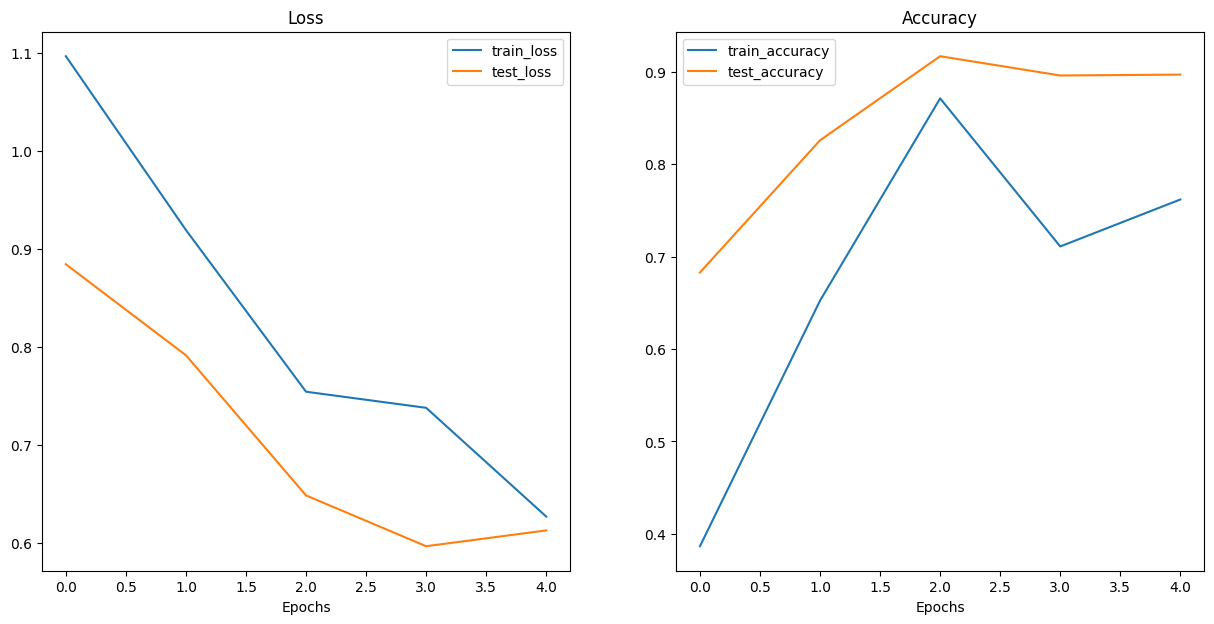

In [54]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

The loss for both training and testing is heading in the right direction, same with accuracy.

This shows how powerful, efficient and useful transfer learning is.

We can say that the model is still slightly underfitting as the training accuracy is still fairly lower than the testing accuracy. Our model is not learning enough from the training data. We can train the model for more epochs for even better results.

## 6. Make predictions on images from the test set

Before inferencing, we need to ensure that the images have the:
1. Same shape
2. Same datatype
3. Same device
4. Same transformations

To do all of this, let's create a function `pred_and_plot_image()`.

In [56]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

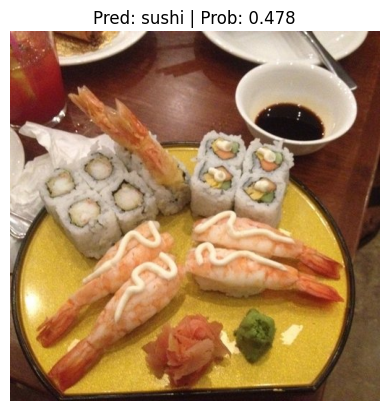

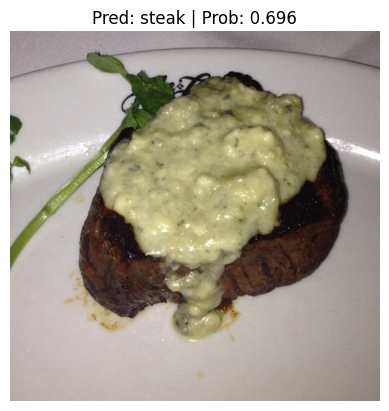

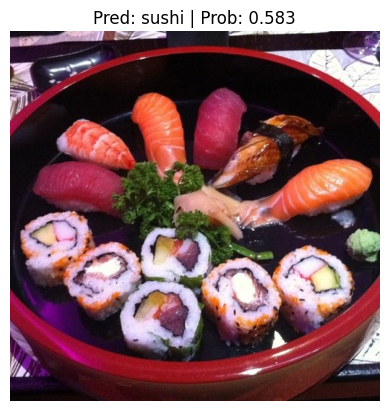

In [60]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))     # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot)    # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on custom image

data\04-pizza-dad.jpeg already exists, skipping download.


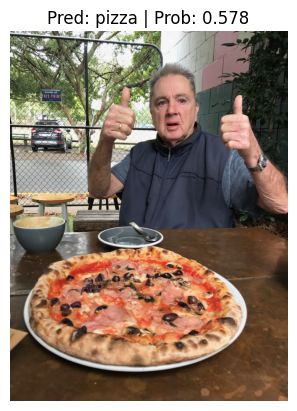

In [61]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)